In [55]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, Kernel, Matern
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Categorical
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ks_2samp
data_dir = 'data'

In [2]:
def compute_kernel(X, Y, kernel: Kernel):
    """
    Compute the kernel matrix for the given data and kernel.

    Parameters:
    X : array-like, shape (n_samples_X, n_features)
        First set of samples.
    Y : array-like, shape (n_samples_Y, n_features)
        Second set of samples.
    kernel : kernels.Kernel
        The kernel function to use for computing the kernel matrix.

    Returns:
    K : array-like, shape (n_samples_X, n_samples_Y)
        The kernel matrix computed between X and Y.
    """
    return kernel(X, Y)

def compute_mmd(X, Y, kernel: Kernel):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two distributions using the specified kernel.
    """
    K_XX = compute_kernel(X, X, kernel)
    K_YY = compute_kernel(Y, Y, kernel)
    K_XY = compute_kernel(X, Y, kernel)

    mmd = np.mean(K_XX) + np.mean(K_YY) - 2 * np.mean(K_XY)
    return mmd

In [3]:
# Reference: https://github.com/jindongwang/transferlearning/blob/master/code/traditional/KMM.py
class KMM:
    def __init__(self, kernel: Kernel = RBF(length_scale=1.0), epsilon: float | None = None, bounding_weights = 1000):
        '''
        Kernel Mean Matching (KMM) for covariate shift correction.
        :param kernel: Kernel to be used for computing the similarity between samples. Default is RBF kernel with unit isotropic length scale.
        :param epsilon: Controls deviation of weights from source distribution. If None, it is set to (sqrt(n_s) - 1) / sqrt(n_s) where n_s is the number of samples in the source set.
        :param bounding_weights: Bounding weights for the importance weights. Default is 1000.
        '''
        self.kernel = kernel
        self.epsilon = epsilon
        self.bounding_weights = bounding_weights

    def fit(self, X_source, X_target):
        """
        Fit the KMM model to the source and target data.

        Parameters:
        X_source : array-like, shape (n_samples_source, n_features)
            source distribution
        X_target : array-like, shape (n_samples_target, n_features)
            target distribution

        Returns:
        beta : array-like, shape (n_samples_source,)
            Importance weights for the source samples.

        """
        self.X_source = X_source
        self.X_target = X_target

        n_s = X_source.shape[0]
        n_t = X_target.shape[0]

        if self.epsilon is None:
            # Default epsilon value based on the number of samples in the source set
            self.epsilon = (np.sqrt(n_s) - 1) / np.sqrt(n_s) # or default could be self.B / np.sqrt(ns)

        K = compute_kernel(X_source, X_source, self.kernel)
        kappa = np.sum(compute_kernel(X_source, X_target, self.kernel) * float(n_s) / float(n_t), axis = 1)

        K = matrix(K.astype(np.double))
        kappa = matrix(kappa.astype(np.double))

        G = matrix(np.r_[np.ones((1, n_s)), -np.ones((1, n_s)), np.eye(n_s), -np.eye(n_s)])
        h = matrix(np.r_[n_s * (1 + self.epsilon), n_s * (self.epsilon - 1), self.bounding_weights * np.ones((n_s,)), np.zeros((n_s,))])

        sol = solvers.qp(K, -kappa, G, h)
        beta = np.array(sol['x'])
        return beta

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'CSF_COG_PET_data_cleaned.csv'))
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 188 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    TAU_bl                         float64
 1    PTAU_bl                        float64
 2    ABETA_bl                       float64
 3    DX_bl                          int64  
 4    DX                             int64  
 5    AGE                            float64
 6    PTGENDER                       int64  
 7    PTEDUCAT                       int64  
 8    PTRACCAT                       float64
 9    MMSE_bl                        float64
 10   EcogPtTotal_bl                 float64
 11   FHQMOM                         float64
 12   FHQMOMAD                       float64
 13   FHQDAD                         float64
 14   FHQDADAD                       float64
 15   LDELTOTAL_BL                   float64
 16   mPACCdigit_bl                  float64
 17   mPACCtrailsB_bl                fl

Preprocess the data

In [5]:
cols_to_normalize = [
    'PTEDUCAT',
    'MMSE_bl',
    'EcogPtTotal_bl',
    'LDELTOTAL_BL',
    'mPACCdigit_bl',
    'mPACCtrailsB_bl',
    'RAVLT_immediate_bl',
    'SUVr_ACC_pre_L.nii',
    'SUVr_ACC_pre_R.nii',
    'SUVr_ACC_sub_L.nii',
    'SUVr_ACC_sub_R.nii',
    'SUVr_Angular_L.nii',
    'SUVr_Angular_R.nii',
    'SUVr_Calcarine_L.nii',
    'SUVr_Cingulate_Mid_L.nii',
    'SUVr_Cingulate_Mid_R.nii',
    'SUVr_Cuneus_L.nii',
    'SUVr_Cuneus_R.nii',
    'SUVr_Frontal_Inf_Oper_L.nii',
    'SUVr_Frontal_Inf_Oper_R.nii',
    'SUVr_Frontal_Inf_Orb_2_L.nii',
    'SUVr_Frontal_Inf_Orb_2_R.nii',
    'SUVr_Frontal_Inf_Tri_L.nii',
    'SUVr_Frontal_Inf_Tri_R.nii',
    'SUVr_Frontal_Med_Orb_L.nii',
    'SUVr_Frontal_Med_Orb_R.nii',
    'SUVr_Frontal_Mid_2_L.nii',
    'SUVr_Frontal_Mid_2_R.nii',
    'SUVr_Frontal_Sup_2_L.nii',
    'SUVr_Frontal_Sup_2_R.nii',
    'SUVr_Frontal_Sup_Medial_L.nii',
    'SUVr_Frontal_Sup_Medial_R.nii',
    'SUVr_Fusiform_L.nii',
    'SUVr_Fusiform_R.nii',
    'SUVr_Insula_L.nii',
    'SUVr_Insula_R.nii',
    'SUVr_Lingual_L.nii',
    'SUVr_Lingual_R.nii',
    'SUVr_Occipital_Inf_L.nii',
    'SUVr_Occipital_Inf_R.nii',
    'SUVr_Occipital_Mid_L.nii',
    'SUVr_Occipital_Mid_R.nii',
    'SUVr_OFCmed_L.nii',
    'SUVr_OFCmed_R.nii',
    'SUVr_OFCpost_L.nii',
    'SUVr_OFCpost_R.nii',
    'SUVr_Olfactory_L.nii',
    'SUVr_Olfactory_R.nii',
    'SUVr_Pallidum_L.nii',
    'SUVr_Pallidum_R.nii',
    'SUVr_Parietal_Inf_L.nii',
    'SUVr_Parietal_Inf_R.nii',
    'SUVr_Parietal_Sup_L.nii',
    'SUVr_Parietal_Sup_R.nii',
    'SUVr_Precuneus_L.nii',
    'SUVr_Precuneus_R.nii',
    'SUVr_Putamen_L.nii',
    'SUVr_Putamen_R.nii',
    'SUVr_Rectus_L.nii',
    'SUVr_Rectus_R.nii',
    'SUVr_Rolandic_Oper_L.nii',
    'SUVr_Rolandic_Oper_R.nii',
    'SUVr_Supp_Motor_Area_L.nii',
    'SUVr_Supp_Motor_Area_R.nii',
    'SUVr_SupraMarginal_L.nii',
    'SUVr_SupraMarginal_R.nii',
    'SUVr_Temporal_Inf_L.nii',
    'SUVr_Temporal_Inf_R.nii',
    'SUVr_Temporal_Mid_L.nii',
    'SUVr_Temporal_Mid_R.nii',
    'SUVr_Temporal_Sup_L.nii',
    'SUVr_Temporal_Sup_R.nii'
]

In [6]:
def yeotransform(series: pd.DataFrame) -> pd.DataFrame:
    transformer = PowerTransformer(method='yeo-johnson')
    transformed_series = transformer.fit_transform(series)
    return pd.DataFrame(transformed_series, index=series.index)

In [7]:
df.drop(columns=['DX_bl', 'DX', 'FHQMOM',  'FHQMOMAD',  'FHQDAD',  'FHQDADAD', 'RAVLT_perc_forgetting_bl'], inplace=True)

yeo_transformed = yeotransform(df[cols_to_normalize[4:]])
feature_names = yeo_transformed.columns.to_list()
df[cols_to_normalize[4:]] = yeo_transformed

df['EcogPtTotal_bl'] = np.log(df['EcogPtTotal_bl'].values - 0.6)
df['PTEDUCAT'] = np.gradient(df['PTEDUCAT'])
df['MMSE_bl'] = np.gradient(df['MMSE_bl'])
df['TAU_bl'] = np.log(df['TAU_bl'])
df['PTAU_bl'] = np.log(df['PTAU_bl'])

In [119]:
df['PTEDUCAT'].value_counts()

PTEDUCAT
16    137
18     98
20     85
12     63
14     59
19     30
17     25
15     20
13     16
11      2
10      1
9       1
8       1
Name: count, dtype: int64

In [120]:
# Split the data into two sets based on the 'PTEDUCAT' column - below 15 and above 15
uni_education_df = df[df['PTEDUCAT'] > 15]
school_education_df = df[df['PTEDUCAT'] <= 15]

In [121]:
uni_education_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 375 entries, 0 to 537
Columns: 188 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(184), int64(4)
memory usage: 553.7 KB


In [64]:
school_education_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 1 to 539
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 240.9 KB


In [12]:
# Define the kernel to be used for MMD computation
kernel = RBF(length_scale=1.0)

In [81]:
# Compute MMD between the training and test sets
mmd_education = compute_mmd(uni_education_df, school_education_df, kernel)
print(f'MMD between training and test sets: {mmd_education:.4f}')

MMD between training and test sets: 0.0087


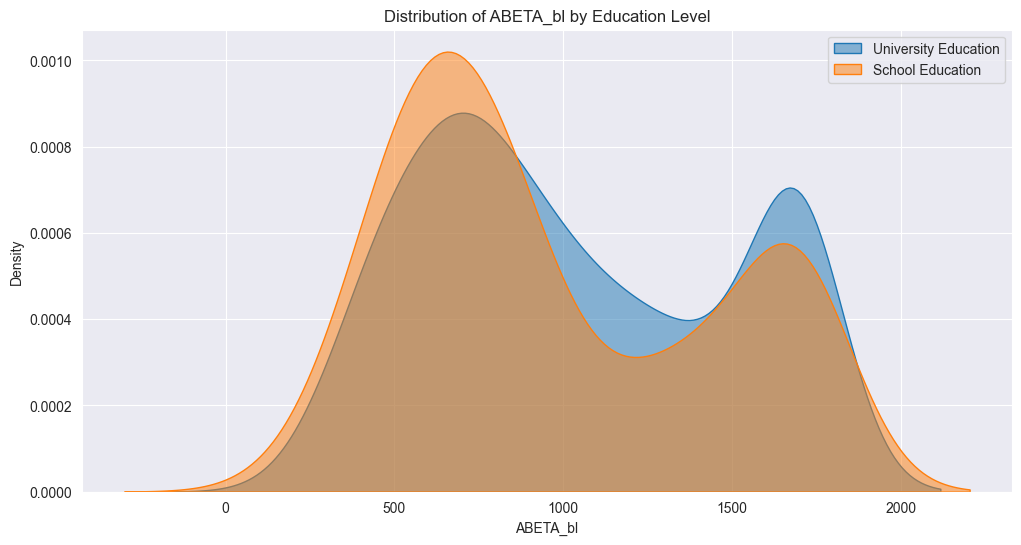

In [66]:
# Visualize the distributions of the two groups
plt.figure(figsize=(12, 6))
sns.kdeplot(uni_education_df['ABETA_bl'], label='University Education', fill=True, alpha=0.5)
sns.kdeplot(school_education_df['ABETA_bl'], label='School Education', fill=True, alpha=0.5)
plt.title('Distribution of ABETA_bl by Education Level')
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

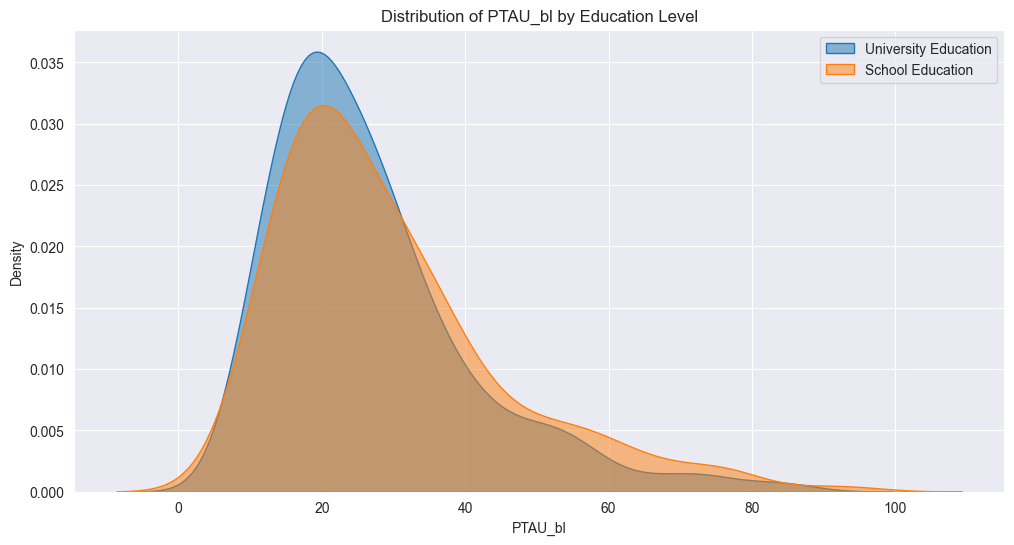

In [89]:
# Visualize the distributions of the two groups
plt.figure(figsize=(12, 6))
sns.kdeplot(uni_education_df['PTAU_bl'], label='University Education', fill=True, alpha=0.5)
sns.kdeplot(school_education_df['PTAU_bl'], label='School Education', fill=True, alpha=0.5)
plt.title('Distribution of PTAU_bl by Education Level')
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

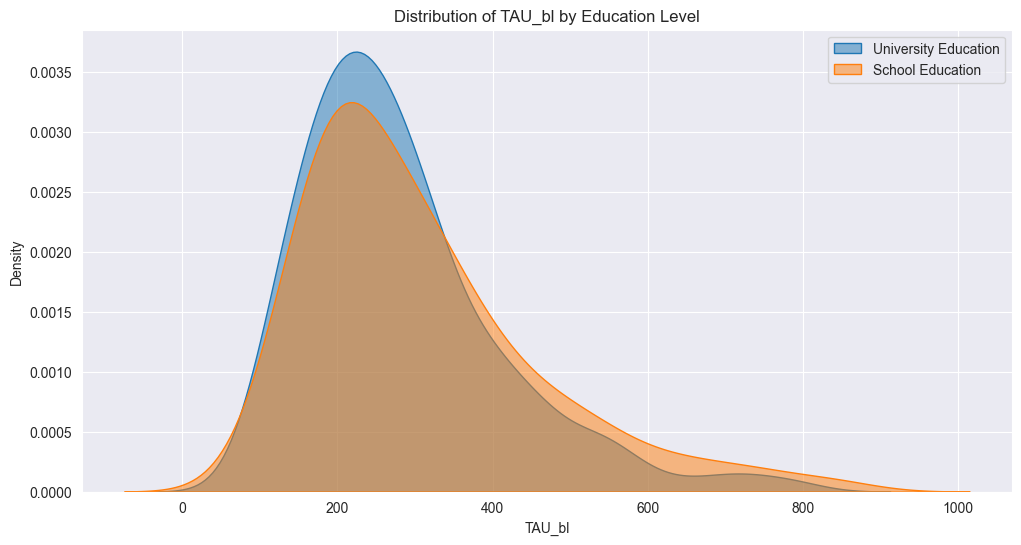

In [90]:
# Visualize the distributions of the two groups
plt.figure(figsize=(12, 6))
sns.kdeplot(uni_education_df['TAU_bl'], label='University Education', fill=True, alpha=0.5)
sns.kdeplot(school_education_df['TAU_bl'], label='School Education', fill=True, alpha=0.5)
plt.title('Distribution of TAU_bl by Education Level')
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

In [78]:
older_age_df = df[df['AGE'] > 70]
younger_age_df = df[df['AGE'] <= 70]

In [79]:
older_age_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 1 to 541
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 515.5 KB


In [80]:
younger_age_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 0 to 542
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 282.0 KB


In [82]:
mmd_age = compute_mmd(older_age_df, younger_age_df, kernel)
print(f'MMD between older and younger age groups: {mmd_age:.4f}')

MMD between older and younger age groups: 0.0081


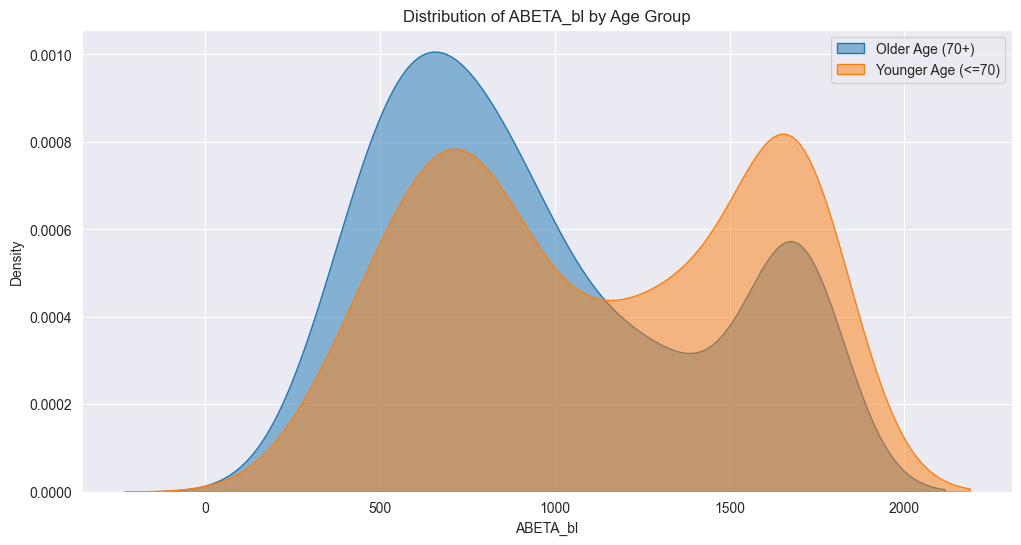

In [83]:
# Visualize the distributions of the two age groups
plt.figure(figsize=(12, 6))
sns.kdeplot(older_age_df['ABETA_bl'], label='Older Age (70+)', fill=True, alpha=0.5)
sns.kdeplot(younger_age_df['ABETA_bl'], label='Younger Age (<=70)', fill=True, alpha=0.5)
plt.title('Distribution of ABETA_bl by Age Group')
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

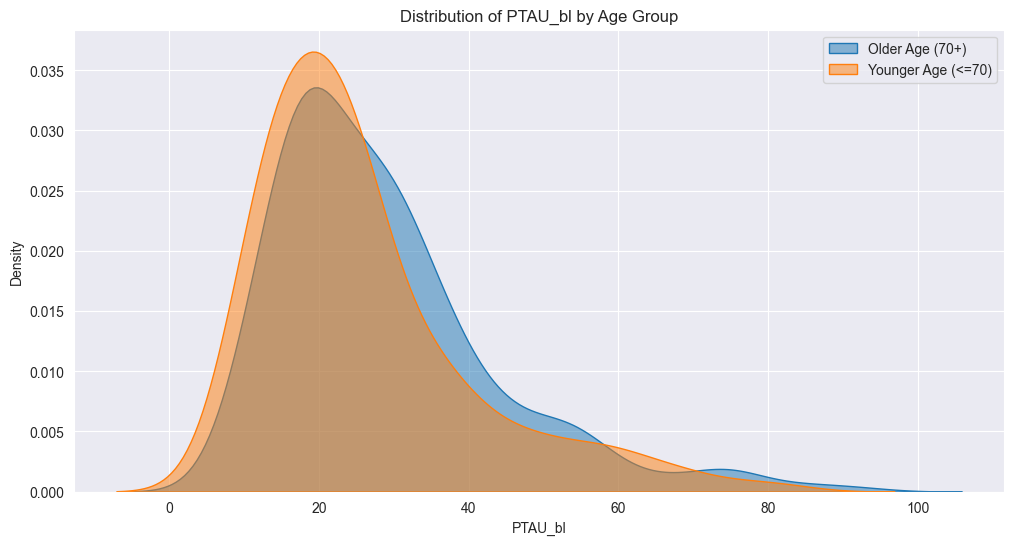

In [91]:
# Visualize the distributions of the two age groups
plt.figure(figsize=(12, 6))
sns.kdeplot(older_age_df['PTAU_bl'], label='Older Age (70+)', fill=True, alpha=0.5)
sns.kdeplot(younger_age_df['PTAU_bl'], label='Younger Age (<=70)', fill=True, alpha=0.5)
plt.title('Distribution of PTAU_bl by Age Group')
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

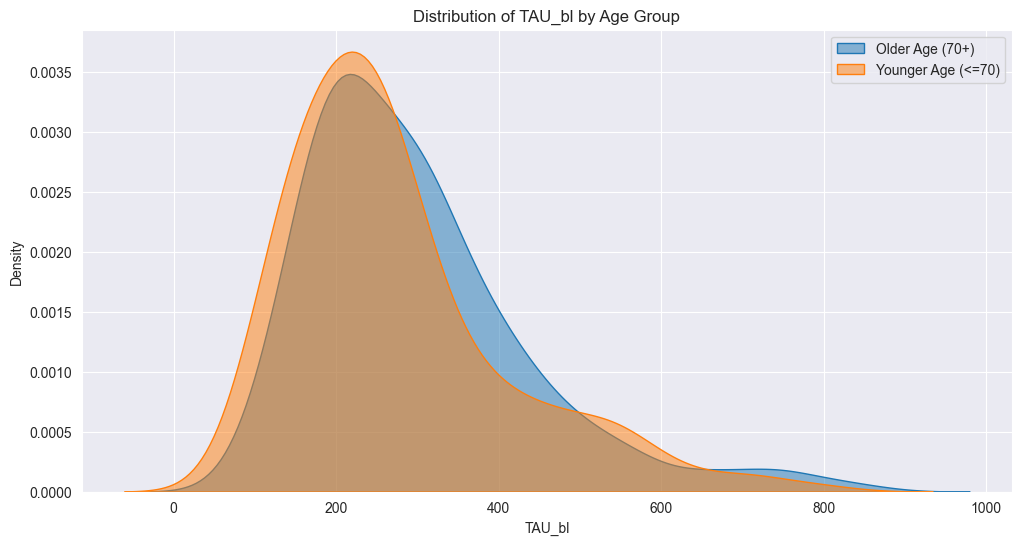

In [92]:
# Visualize the distributions of the two age groups
plt.figure(figsize=(12, 6))
sns.kdeplot(older_age_df['TAU_bl'], label='Older Age (70+)', fill=True, alpha=0.5)
sns.kdeplot(younger_age_df['TAU_bl'], label='Younger Age (<=70)', fill=True, alpha=0.5)
plt.title('Distribution of TAU_bl by Age Group')
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

In [84]:
male_df = df[df['PTGENDER'] == 0]
female_df = df[df['PTGENDER'] == 1]

In [85]:
male_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 0 to 542
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 420.1 KB


In [86]:
female_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257 entries, 1 to 541
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 377.5 KB


In [87]:
mmd_gender = compute_mmd(male_df, female_df, kernel)
print(f'MMD between males and females: {mmd_gender}')

MMD between males and females: 0.007387554080161084


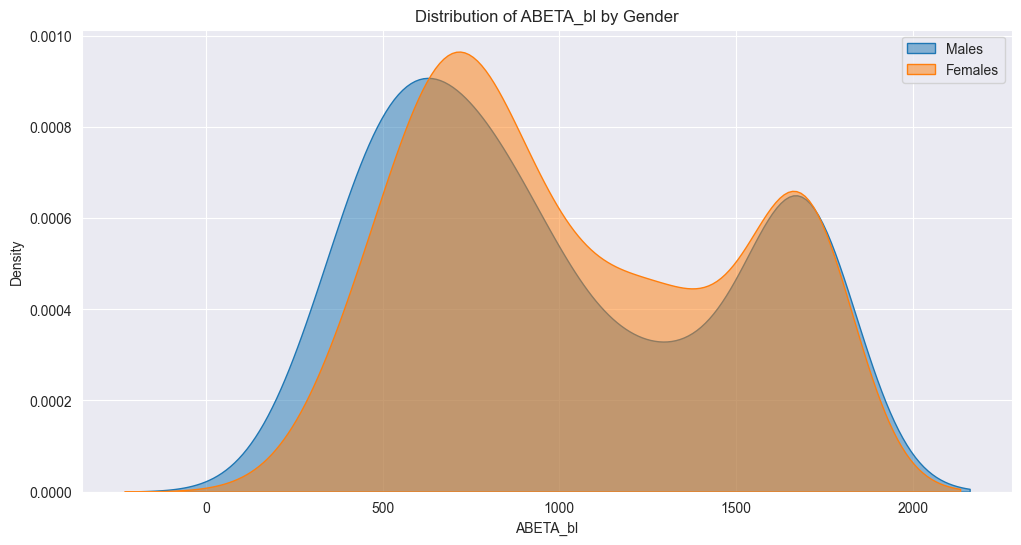

In [88]:
# Visualize the distributions of the two genders
plt.figure(figsize=(12, 6))
sns.kdeplot(male_df['ABETA_bl'], label='Males', fill=True, alpha=0.5)
sns.kdeplot(female_df['ABETA_bl'], label='Females', fill=True, alpha=0.5)
plt.title('Distribution of ABETA_bl by Gender')
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

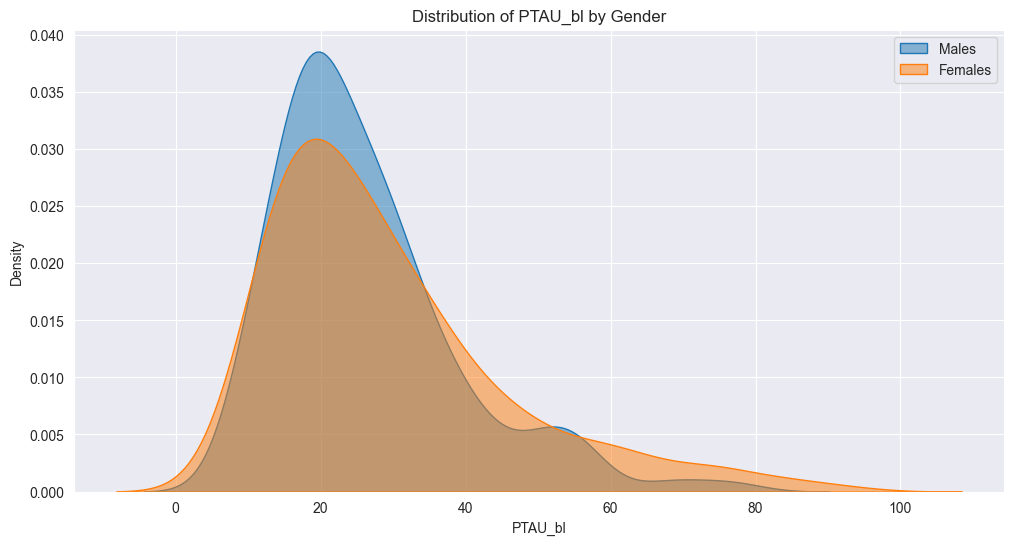

In [93]:
# Visualize the distributions of the two genders
plt.figure(figsize=(12, 6))
sns.kdeplot(male_df['PTAU_bl'], label='Males', fill=True, alpha=0.5)
sns.kdeplot(female_df['PTAU_bl'], label='Females', fill=True, alpha=0.5)
plt.title('Distribution of PTAU_bl by Gender')
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

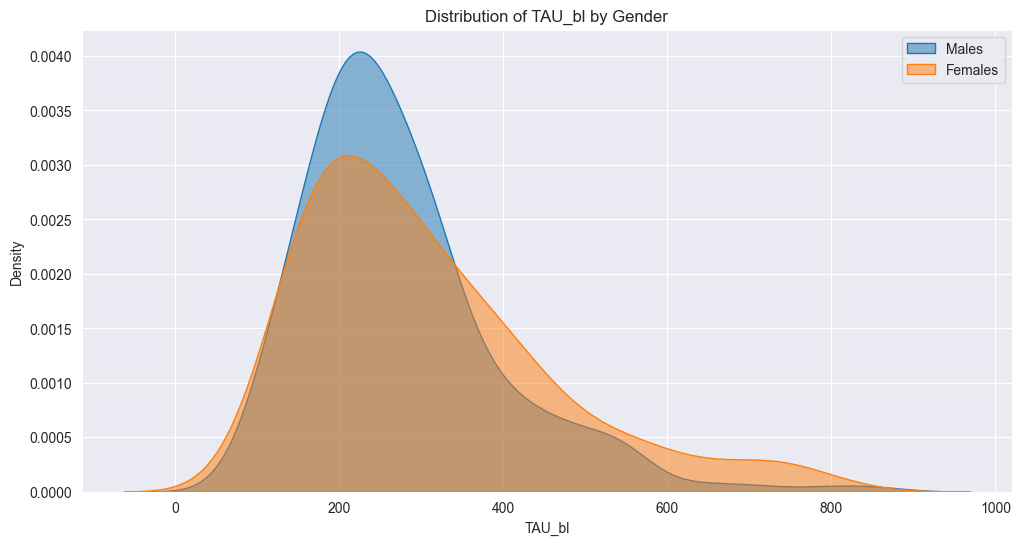

In [94]:
# Visualize the distributions of the two genders
plt.figure(figsize=(12, 6))
sns.kdeplot(male_df['TAU_bl'], label='Males', fill=True, alpha=0.5)
sns.kdeplot(female_df['TAU_bl'], label='Females', fill=True, alpha=0.5)
plt.title('Distribution of TAU_bl by Gender')
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

In [8]:
whites_df = df[df['PTRACCAT'] == 0]
non_whites_df = df[df['PTRACCAT'] != 0]

In [9]:
whites_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 1 to 536
Columns: 181 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(180), int64(1)
memory usage: 716.6 KB


In [10]:
non_whites_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 0 to 537
Columns: 181 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(180), int64(1)
memory usage: 48.3 KB


In [13]:
mmd_race = compute_mmd(whites_df, non_whites_df, kernel)
print(f'MMD between whites and non-whites: {mmd_race:.4f}')

MMD between whites and non-whites: 0.0314


In [67]:
failed_columns = []
count_whites_df = whites_df.drop(['TAU_bl', 'PTAU_bl', 'PTRACCAT', 'ABETA_bl'], axis=1)
count_non_whites_df = non_whites_df.drop(['TAU_bl', 'PTAU_bl', 'PTRACCAT', 'ABETA_bl'], axis=1)
for col in count_whites_df.columns:
    # if col not in non_whites_df.columns:
    #     continue
    # # Only test numeric columns
    # if not np.issubdtype(whites_df[col].dtype, np.number):
    #     continue
    ks_stat, ks_pvalue = ks_2samp(count_whites_df[col].dropna(), count_non_whites_df[col].dropna())
    if ks_pvalue <= 0.05:
        failed_columns.append(col)

# print("Columns that failed the K-S test at 5% significance level:", failed_columns)
print(f'{len(failed_columns)} out of {len(whites_df.columns)}, i.e., {len(failed_columns)/len(whites_df.columns):.2f}% columns failed the K-S test at 5% significance level: {failed_columns}')

4 out of 181, i.e., 0.02% columns failed the K-S test at 5% significance level: ['SUVr_Cerebellum_8_R.nii', 'SUVr_Parietal_Sup_R.nii', 'SUVr_SupraMarginal_R.nii', 'SUVr_Thal_AV_L.nii']


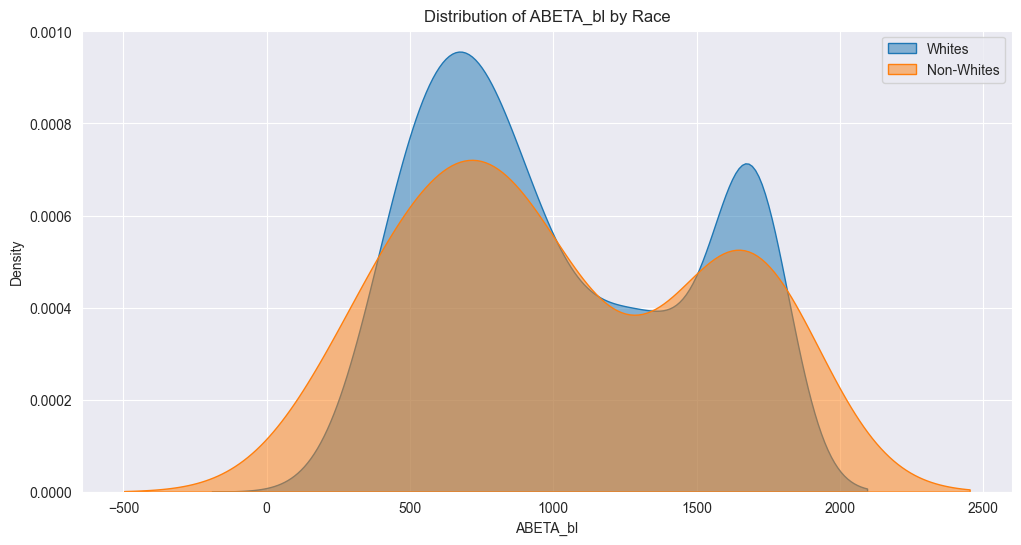

In [14]:
# Visualize the distributions of the race groups
plt.figure(figsize=(12, 6))
sns.kdeplot(whites_df['ABETA_bl'], label='Whites', fill=True, alpha=0.5)
sns.kdeplot(non_whites_df['ABETA_bl'], label='Non-Whites', fill=True, alpha=0.5)
plt.title('Distribution of ABETA_bl by Race')
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

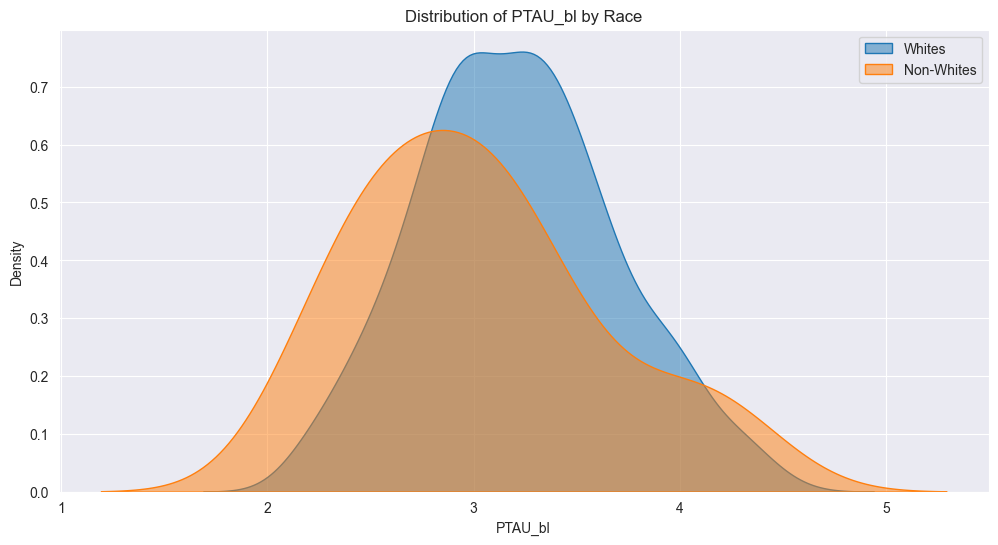

In [15]:
# Visualize the distributions of the race groups
plt.figure(figsize=(12, 6))
sns.kdeplot(whites_df['PTAU_bl'], label='Whites', fill=True, alpha=0.5)
sns.kdeplot(non_whites_df['PTAU_bl'], label='Non-Whites', fill=True, alpha=0.5)
plt.title('Distribution of PTAU_bl by Race')
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

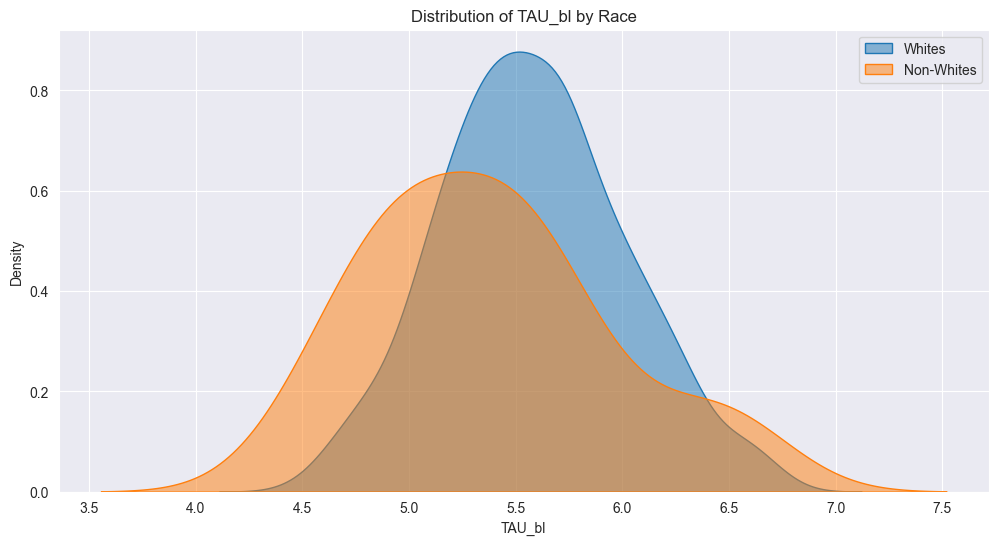

In [16]:
# Visualize the distributions of the race groups
plt.figure(figsize=(12, 6))
sns.kdeplot(whites_df['TAU_bl'], label='Whites', fill=True, alpha=0.5)
sns.kdeplot(non_whites_df['TAU_bl'], label='Non-Whites', fill=True, alpha=0.5)
plt.title('Distribution of TAU_bl by Race')
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

# Bayesian Hyperparameter Optimization Setup

In [17]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    elif name == "RBF_1e-5":
        return RBF(length_scale=1e-5)
    elif name == "RBF_1e-4":
        return RBF(length_scale=1e-4)
    elif name == "RBF_1e-3":
        return RBF(length_scale=1e-3)
    elif name == "RBF_1e-2":
        return RBF(length_scale=1e-2)
    elif name == "RBF_1e-1":
        return RBF(length_scale=1e-1)
    elif name == "RBF_1e0":
        return RBF(length_scale=1e0)
    elif name == "RBF_1e1":
        return RBF(length_scale=1e1)
    elif name == "RBF_1e2":
        return RBF(length_scale=1e2)
    elif name == "Matern_1e-5":
        return Matern(length_scale=1e-5, nu=2.5)
    elif name == "Matern_1e-4":
        return Matern(length_scale=1e-4, nu=2.5)
    elif name == "Matern_1e-3":
        return Matern(length_scale=1e-3, nu=2.5)
    elif name == "Matern_1e-2":
        return Matern(length_scale=1e-2, nu=2.5)
    elif name == "Matern_1e-1":
        return Matern(length_scale=1e-1, nu=2.5)
    elif name == "Matern_1e0":
        return Matern(length_scale=1e0, nu=2.5)
    elif name == "Matern_1e1":
        return Matern(length_scale=1e1, nu=2.5)
    elif name == "Matern_1e2":
        return Matern(length_scale=1e2, nu=2.5)
    else:
        raise ValueError(f"Unknown kernel: {name}")

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        return super().set_params(**params)

# Single Task Learning without Importance Weighting

Train a normal (without importance weighting) GPR model on the white group and evaluate on the non-white group.

Predict ABETA_bl

In [18]:
X_train = whites_df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis = 1)
y_train = whites_df['ABETA_bl']
X_test = non_whites_df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis = 1)
y_test = non_whites_df['ABETA_bl']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)

(504, 177) (504,) (34, 177) (34,)


In [218]:
kernel = 1 * RBF(length_scale= 1e1,
                 length_scale_bounds = (1e1, 1e3))

gpr = GPRWrapper(
    kernel=kernel,
    alpha=5e-1,
    n_restarts_optimizer=10,
    random_state=42,
    normalize_y=True
)

search_params = {
    'kernel': Categorical([
        'RQ_1e-5', 'RQ_1e-4', 'RQ_1e-3', 'RQ_1e-2', 'RQ_1e-1', 'RQ_1e0', 'RQ_1e1', 'RQ_1e2',
        'RBF_1e-5', 'RBF_1e-4', 'RBF_1e-3', 'RBF_1e-2', 'RBF_1e-1', 'RBF_1e0', 'RBF_1e1', 'RBF_1e2',
        'Matern_1e-5', 'Matern_1e-4', 'Matern_1e-3', 'Matern_1e-2', 'Matern_1e-1', 'Matern_1e0', 'Matern_1e1', 'Matern_1e2'
    ]),
    'alpha': (1e-5, 1e2, 'log-uniform')
}

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f"Best parameters: {search.best_params_}, Best R2 score: {search.best_score_:.2f}")

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Dhruv K

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: OrderedDict({'alpha': 0.3117951071048876, 'kernel': 'RQ_1e-5'}), Best R2 score: -0.47


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [220]:
# Train on the best hyperparameters

kernel = 1 * RationalQuadratic(length_scale= 1e-5,
                 length_scale_bounds = (1e1, 1e3))

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.311,
                               n_restarts_optimizer= 10,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * Ration...h_scale=1e-05)
,alpha,0.311
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr...h_scale=1e-05)
,kernel__k1__constant_value,1


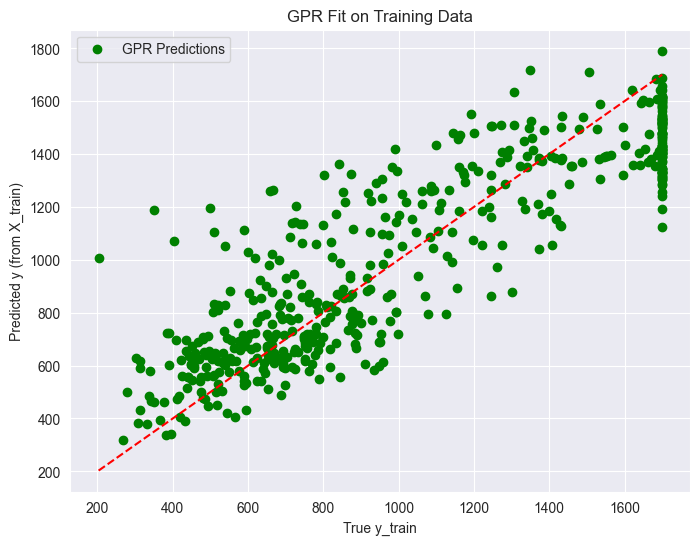

MSE: 48728.13320528935
Rsquared: 0.7663410553084486


In [221]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--')
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

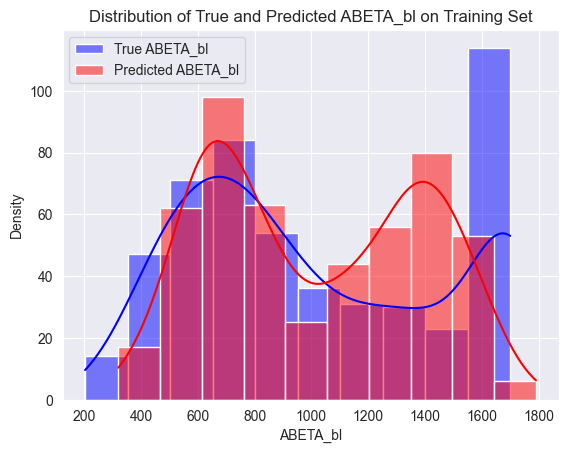

In [222]:
# Plot the distribution of training set predictions and the true values
sns.histplot(y_train, color='blue', label='True ABETA_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted ABETA_bl', kde=True)
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted ABETA_bl on Training Set')
plt.legend()
plt.show()

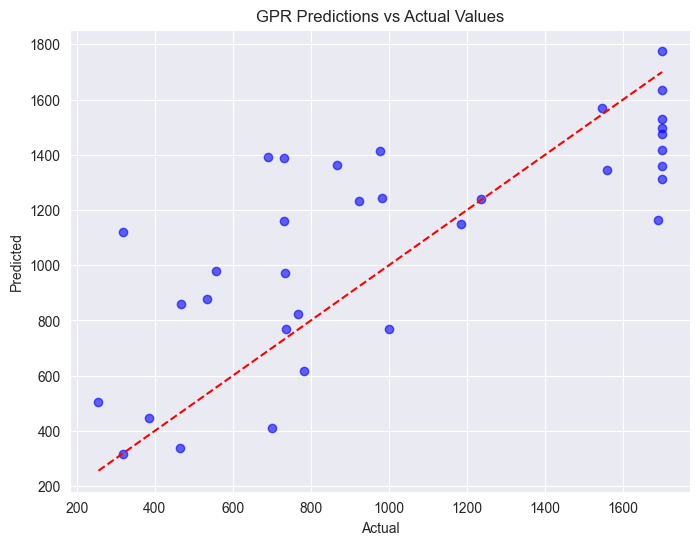

MSE: 115021.11542183618
Rsquared: 0.5410168389786059


In [223]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

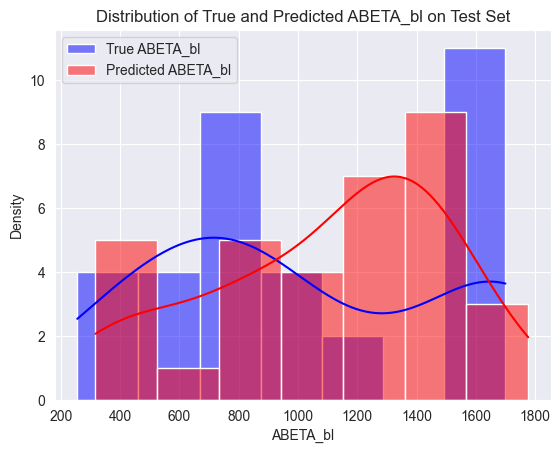

In [224]:
# Plot the distribution of test set predictions and the true values
sns.histplot(y_test, color='blue', label='True ABETA_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted ABETA_bl', kde=True)
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted ABETA_bl on Test Set')
plt.legend()
plt.show()

Predict PTAU_bl

In [226]:
X_train = whites_df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis = 1)
y_train = whites_df['PTAU_bl']
X_test = non_whites_df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis = 1)
y_test = non_whites_df['PTAU_bl']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)

(504, 177) (504,) (34, 177) (34,)


In [227]:
kernel = 1 * RBF(length_scale= 1e1,
                 length_scale_bounds = (1e1, 1e3))

gpr = GPRWrapper(
    kernel=kernel,
    alpha=5e-1,
    n_restarts_optimizer=10,
    random_state=42,
    normalize_y=True
)

search_params = {
    'kernel': Categorical([
        'RQ_1e-5', 'RQ_1e-4', 'RQ_1e-3', 'RQ_1e-2', 'RQ_1e-1', 'RQ_1e0', 'RQ_1e1', 'RQ_1e2',
        'RBF_1e-5', 'RBF_1e-4', 'RBF_1e-3', 'RBF_1e-2', 'RBF_1e-1', 'RBF_1e0', 'RBF_1e1', 'RBF_1e2',
        'Matern_1e-5', 'Matern_1e-4', 'Matern_1e-3', 'Matern_1e-2', 'Matern_1e-1', 'Matern_1e0', 'Matern_1e1', 'Matern_1e2'
    ]),
    'alpha': (1e-5, 1e2, 'log-uniform')
}

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f"Best parameters: {search.best_params_}, Best R2 score: {search.best_score_:.2f}")

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Dhruv K

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: OrderedDict({'alpha': 0.6624521612323926, 'kernel': 'RQ_1e-1'}), Best R2 score: 0.30


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [228]:
kernel = 1.00 * RationalQuadratic(length_scale= 1e-1,
                                  alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.66,
                               n_restarts_optimizer= 30,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * Ration...gth_scale=0.1)
,alpha,0.66
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr...gth_scale=0.1)
,kernel__k1__constant_value,1.0


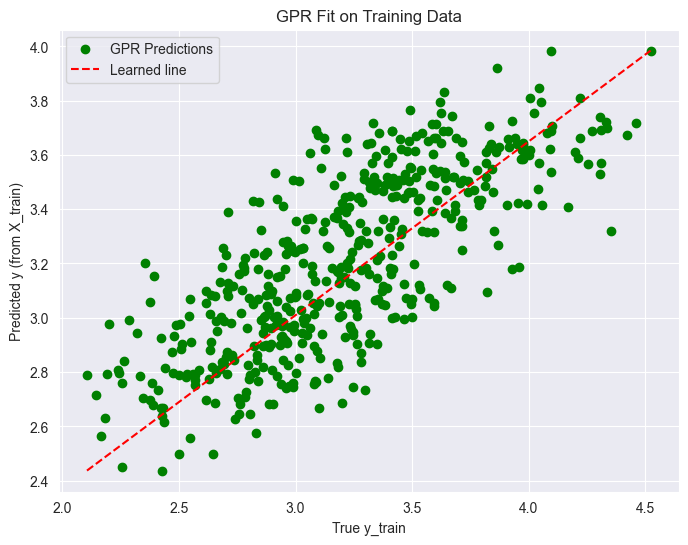

MSE: 0.10026045409767008
Rsquared: 0.5682260525473147


In [229]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label = 'Learned line')
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

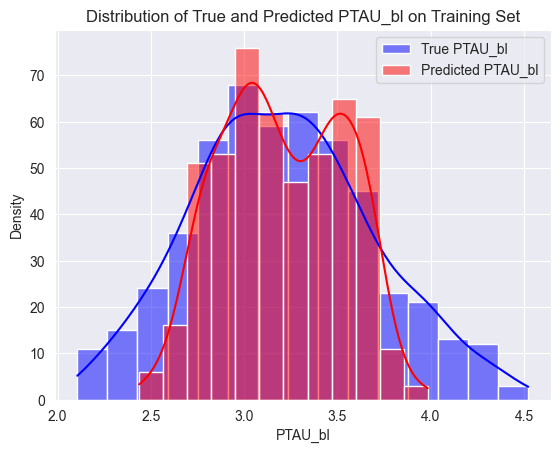

In [230]:
# Plot the distribution of training set predictions and the true values
sns.histplot(y_train, color='blue', label='True PTAU_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted PTAU_bl', kde=True)
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted PTAU_bl on Training Set')
plt.legend()
plt.show()

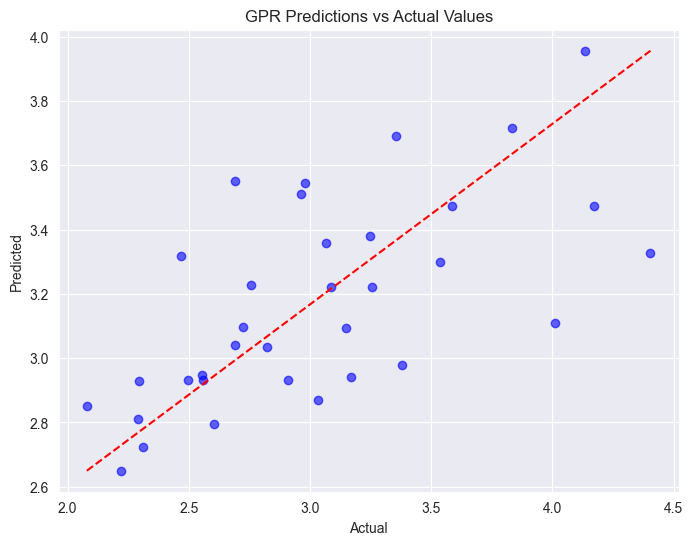

MSE: 0.22949682888683773
Rsquared: 0.33877611168686284


In [231]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

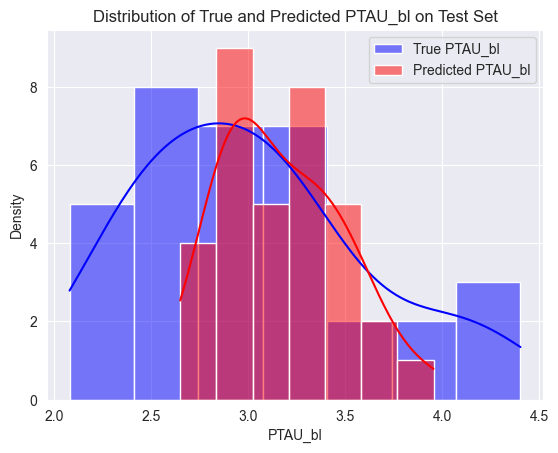

In [232]:
# Plot the distribution of test set predictions and the true values
sns.histplot(y_test, color='blue', label='True PTAU_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted PTAU_bl', kde=True)
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted PTAU_bl on Test Set')
plt.legend()
plt.show()

Predict TAU_bl

In [136]:
X_train = whites_df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis = 1)
y_train = whites_df['TAU_bl']
X_test = non_whites_df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis = 1)
y_test = non_whites_df['TAU_bl']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)

(504, 177) (504,) (34, 177) (34,)


In [19]:
kernel = 1 * RBF(length_scale= 1e1,
                 length_scale_bounds = (1e1, 1e3))

gpr = GPRWrapper(
    kernel=kernel,
    alpha=5e-1,
    n_restarts_optimizer=10,
    random_state=42,
    normalize_y=True
)

search_params = {
    'kernel': Categorical([
        'RQ_1e-5', 'RQ_1e-4', 'RQ_1e-3', 'RQ_1e-2', 'RQ_1e-1', 'RQ_1e0', 'RQ_1e1', 'RQ_1e2',
        'RBF_1e-5', 'RBF_1e-4', 'RBF_1e-3', 'RBF_1e-2', 'RBF_1e-1', 'RBF_1e0', 'RBF_1e1', 'RBF_1e2',
        'Matern_1e-5', 'Matern_1e-4', 'Matern_1e-3', 'Matern_1e-2', 'Matern_1e-1', 'Matern_1e0', 'Matern_1e1', 'Matern_1e2'
    ]),
    'alpha': (1e-5, 1e2, 'log-uniform')
}

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f"Best parameters: {search.best_params_}, Best R2 score: {search.best_score_:.2f}")

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\Dhruv K

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: OrderedDict({'alpha': 0.3117951071048876, 'kernel': 'RQ_1e-5'}), Best R2 score: -0.47


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [20]:
kernel = RationalQuadratic(length_scale=1e-5)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.3117951071048876,
                               n_restarts_optimizer= 10,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,RationalQuadr...h_scale=1e-05)
,alpha,0.3117951071048876
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,1e-05
,kernel__alpha,1.0
,kernel__length_scale_bounds,"(1e-05, ...)"


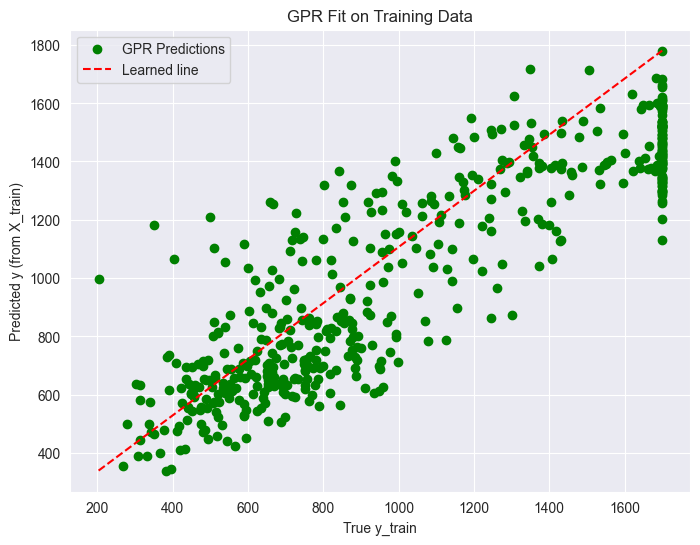

MSE: 48658.79066215267
Rsquared: 0.7666735635410806


In [21]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label = 'Learned line')
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

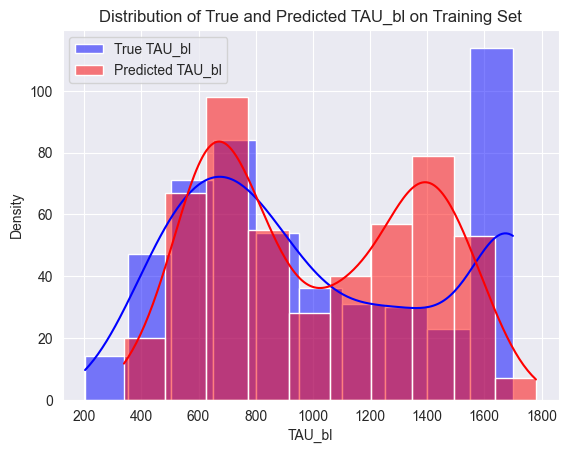

In [22]:
# Plot the distribution of training set predictions and the true values
sns.histplot(y_train, color='blue', label='True TAU_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted TAU_bl', kde=True)
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted TAU_bl on Training Set')
plt.legend()
plt.show()

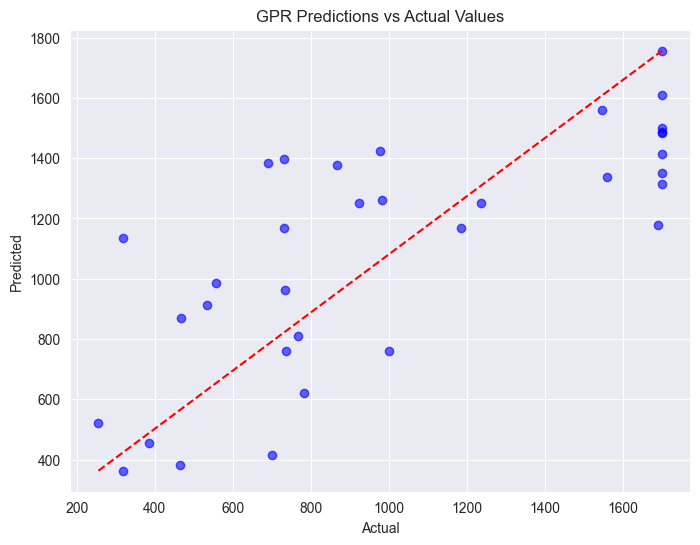

MSE: 118319.3087127415
Rsquared: 0.5278556452554584


In [23]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

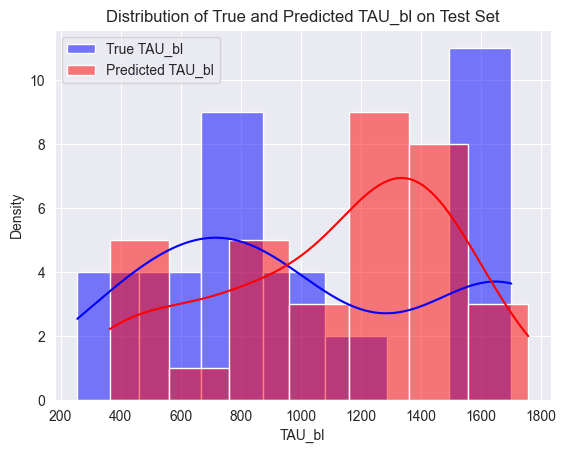

In [24]:
# Plot the distribution of test set predictions and the true values
sns.histplot(y_test, color='blue', label='True TAU_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted TAU_bl', kde=True)
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted TAU_bl on Test Set')
plt.legend()
plt.show()

# Single Task Learning with Importance Weighting

Train a GPR model on the white group with importance weighting and evaluate on the non-white group.

## Kernel Means Matching

Predict ABETA_bl

In [47]:
X_train = whites_df.drop(columns=['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis=1)
y_train = whites_df['ABETA_bl']
X_test = non_whites_df.drop(columns=['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis=1)
y_test = non_whites_df['ABETA_bl']

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(504, 177) (504,) (34, 177) (34,)


In [48]:
# kernel = 1 * RBF(length_scale=1e1,
#                  length_scale_bounds=(1e1, 1e3))

kernel = 1 * RationalQuadratic(length_scale= 1e-5,
                               length_scale_bounds = (1e1, 1e3))

kmm = KMM(kernel=kernel, epsilon=0.1, bounding_weights=1000)

beta = kmm.fit(X_source=X_train, X_target=X_test)

print(f"Computed importance weights of shape: {beta.shape}")
X_train_weighted = X_train * beta
# scaler = StandardScaler()
# X_train_weighted = scaler.fit_transform(X_train_weighted)

print(f'Original X_train shape: {X_train.shape}')
print(f"Weighted X_train shape: {X_train_weighted.shape}")

print(f'is original X_train standardrized? {np.allclose(X_train.mean(axis=0), 0, atol=1e-7) and np.allclose(X_train.std(axis=0), 1, atol=1e-7)}')
print(f'is weighted X_train standardrized? {np.allclose(X_train_weighted.mean(axis=0), 0, atol=1e-7) and np.allclose(X_train_weighted.std(axis=0), 1, atol=1e-7)}')

     pcost       dcost       gap    pres   dres
 0:  9.9409e+02 -1.1016e+06  2e+08  6e-01  5e-12
 1:  3.0862e+02 -6.3813e+05  2e+06  5e-03  1e-08
 2:  3.0492e+02 -3.2376e+05  3e+05  3e-05  9e-10
 3:  3.0490e+02 -3.5486e+03  4e+03  3e-07  1e-11
 4:  3.0488e+02 -3.5361e+02  7e+02  5e-08  2e-12
 5:  3.0234e+02 -3.4655e+02  6e+02  5e-08  2e-12
 6:  2.0501e+02 -4.5496e+02  7e+02  4e-08  2e-12
 7:  3.0382e+02 -3.6957e+02  7e+02  4e-08  1e-12
 8:  3.0121e+02 -1.5066e+02  5e+02  2e-08  8e-13
 9:  2.0500e+02 -2.5709e+02  5e+02  2e-08  7e-13
10:  2.0413e+02  1.9915e+02  5e+00  2e-10  2e-14
11:  2.0412e+02  2.0407e+02  5e-02  2e-12  8e-15
12:  2.0412e+02  2.0412e+02  5e-04  2e-14  6e-15
13:  2.0412e+02  2.0412e+02  5e-06  3e-16  7e-15
Optimal solution found.
Computed importance weights of shape: (504, 1)
Original X_train shape: (504, 177)
Weighted X_train shape: (504, 177)
is original X_train standardrized? False
is weighted X_train standardrized? False


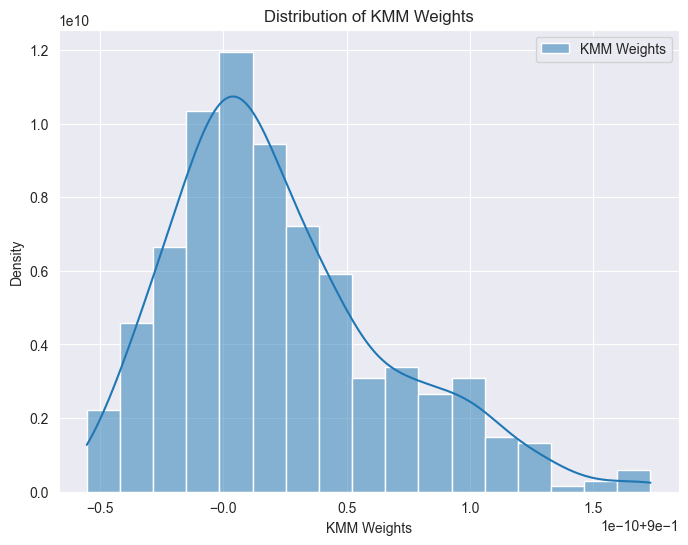

In [68]:
# Plot the distribution of the kmm weights
plt.figure(figsize=(8, 6))
sns.histplot(beta, kde=True, color='blue', label='KMM Weights', stat='density')
plt.xlabel('KMM Weights')
plt.ylabel('Density')
plt.title('Distribution of KMM Weights')
plt.legend()
plt.show()

Mean and std of original X_train: AGE                   72.710913
PTGENDER               0.472222
PTEDUCAT               0.000992
MMSE_bl               -0.003968
EcogPtTotal_bl        -0.029285
                        ...    
SUVr_Vermis_8.nii      0.012286
SUVr_Vermis_9.nii      0.008791
SUVr_Vermis_10.nii     0.006238
SUVr_VTA_L.nii         0.000799
SUVr_VTA_R.nii         0.000733
Length: 177, dtype: float64, AGE                   7.053794
PTGENDER              0.499724
PTEDUCAT              1.905704
MMSE_bl               1.794620
EcogPtTotal_bl        0.453661
                        ...   
SUVr_Vermis_8.nii     0.001163
SUVr_Vermis_9.nii     0.000889
SUVr_Vermis_10.nii    0.000683
SUVr_VTA_L.nii        0.000093
SUVr_VTA_R.nii        0.000086
Length: 177, dtype: float64
Mean and std of weighted X_train: AGE                   65.439821
PTGENDER               0.425000
PTEDUCAT               0.000893
MMSE_bl               -0.003571
EcogPtTotal_bl        -0.026357
                      

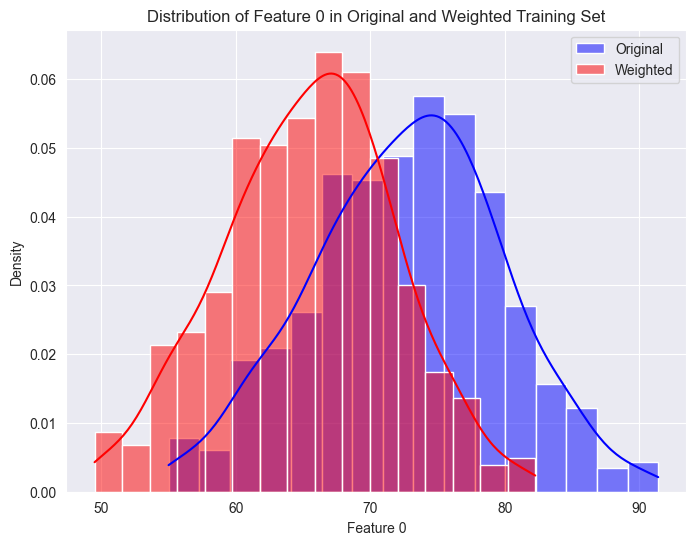

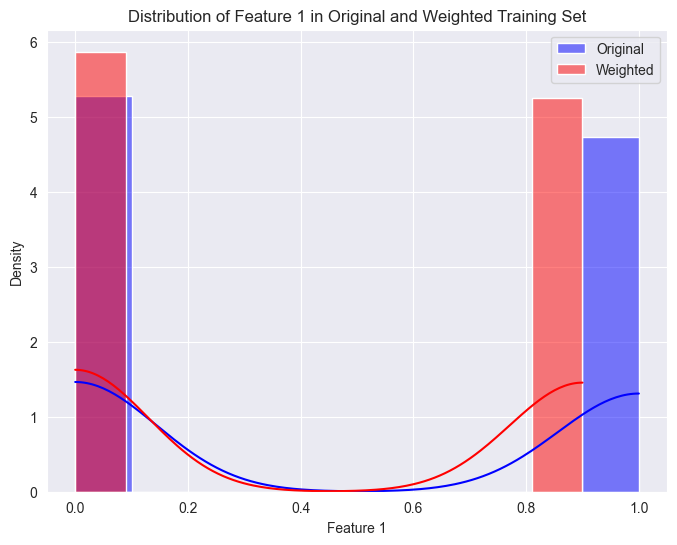

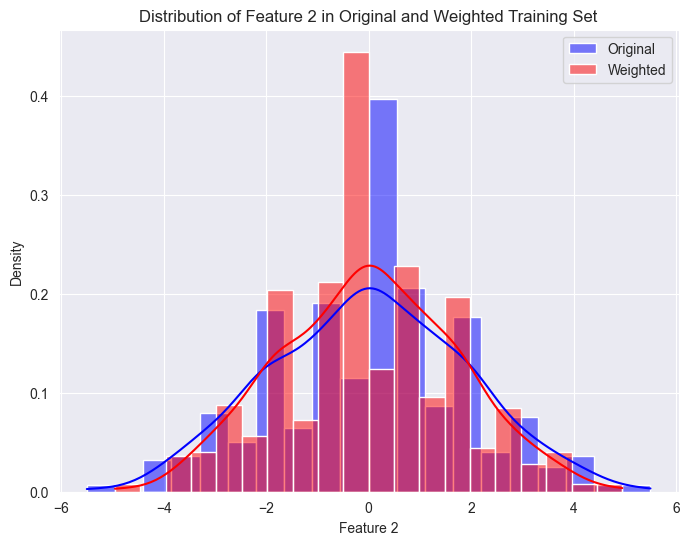

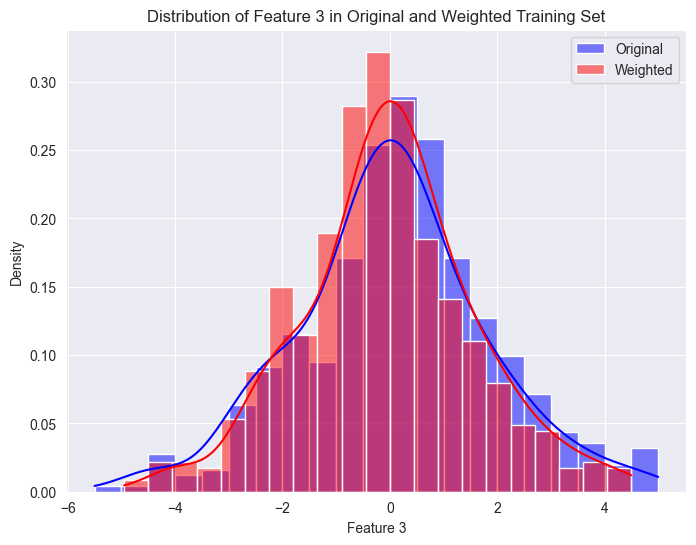

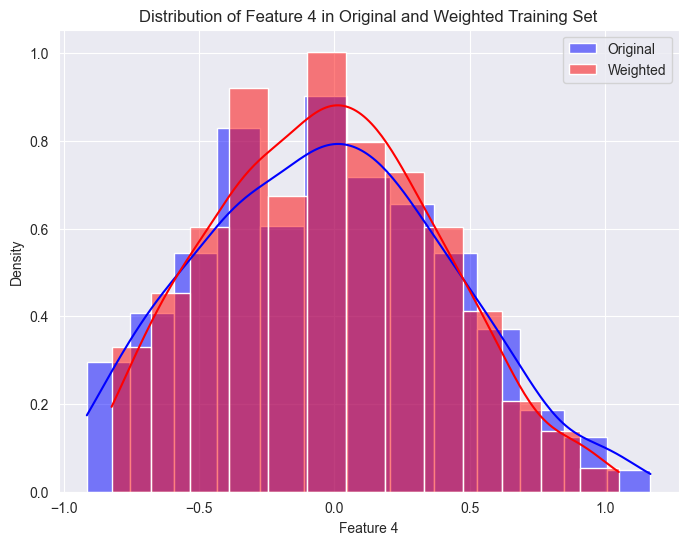

In [54]:
# Plot the distribution of the original and weighted training set
for feature_num in range(X_train.shape[1]):
    if feature_num >= 5:
        continue  # Skip features beyond the first 10 for clarity
    plt.figure(figsize=(8, 6))
    # sns.kdeplot(X_train[:, feature_num], label='Original', fill=True, alpha=0.5)
    # sns.kdeplot(X_train_weighted[:, feature_num], label='Weighted', fill=True, alpha=0.5)
    sns.histplot(X_train.iloc[:, feature_num], label='Original', kde=True, stat='density', color='blue', alpha=0.5)
    sns.histplot(X_train_weighted.iloc[:, feature_num], label='Weighted', kde=True, stat='density', color='red', alpha=0.5)
    plt.title(f'Distribution of Feature {feature_num} in Original and Weighted Training Set')
    plt.xlabel(f'Feature {feature_num}')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [ ]:
# kernel = 1 * RBF(length_scale= 1e1,
#                  length_scale_bounds = (1e1, 1e3))
#
# gpr = GPRWrapper(
#     kernel=kernel,
#     alpha=5e-1,
#     n_restarts_optimizer=10,
#     random_state=42,
#     normalize_y=True
# )
#
# search_params = {
#     'kernel': Categorical([
#         'RQ_1e-5', 'RQ_1e-4', 'RQ_1e-3', 'RQ_1e-2', 'RQ_1e-1', 'RQ_1e0', 'RQ_1e1', 'RQ_1e2',
#         'RBF_1e-5', 'RBF_1e-4', 'RBF_1e-3', 'RBF_1e-2', 'RBF_1e-1', 'RBF_1e0', 'RBF_1e1', 'RBF_1e2',
#         'Matern_1e-5', 'Matern_1e-4', 'Matern_1e-3', 'Matern_1e-2', 'Matern_1e-1', 'Matern_1e0', 'Matern_1e1', 'Matern_1e2'
#     ]),
#     'alpha': (1e-5, 1e2, 'log-uniform')
# }
#
# search = BayesSearchCV(
#     gpr,
#     search_params,
#     n_iter=50,
#     cv=5,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42,
# )
#
# search.fit(X_train_weighted, y_train)
#
# print(f"Best parameters: {search.best_params_}, Best R2 score: {search.best_score_:.2f}")

In [37]:
# gpr = GaussianProcessRegressor(kernel=kernel,
#                                alpha=5e-1,
#                                n_restarts_optimizer=10,
#                                random_state=42,
#                                normalize_y=True)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.311,
                               n_restarts_optimizer= 10,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train_weighted, y_train)

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * Ration...h_scale=1e-05)
,alpha,0.311
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr...h_scale=1e-05)
,kernel__k1__constant_value,1


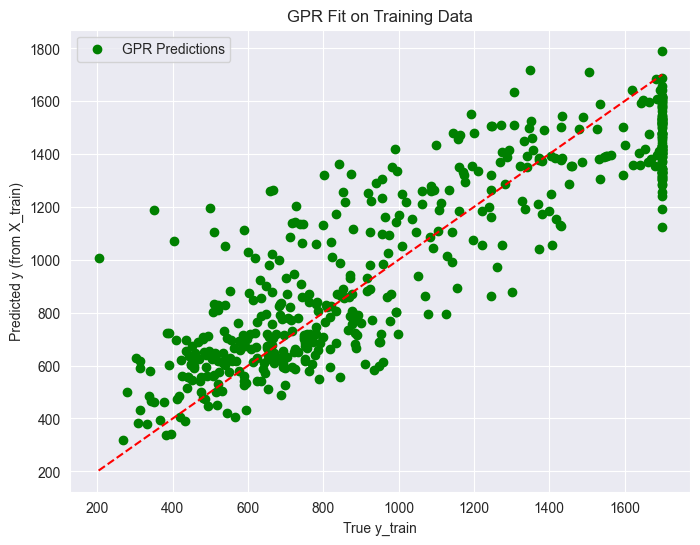

MSE: 48728.38433427562
Rsquared: 0.76633985110607


In [38]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--')
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

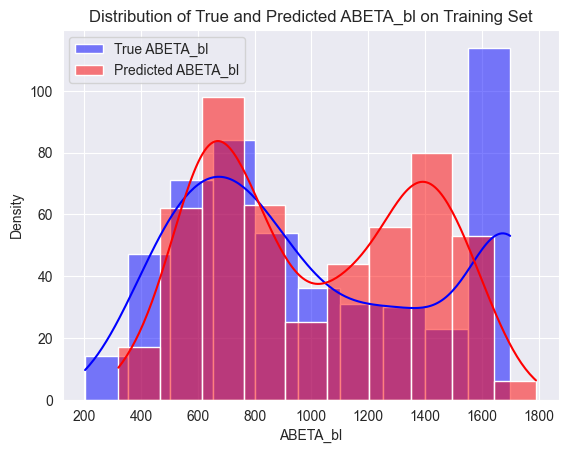

In [39]:
# Plot the distribution of training set predictions and the true values
sns.histplot(y_train, color='blue', label='True ABETA_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted ABETA_bl', kde=True)
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted ABETA_bl on Training Set')
plt.legend()
plt.show()

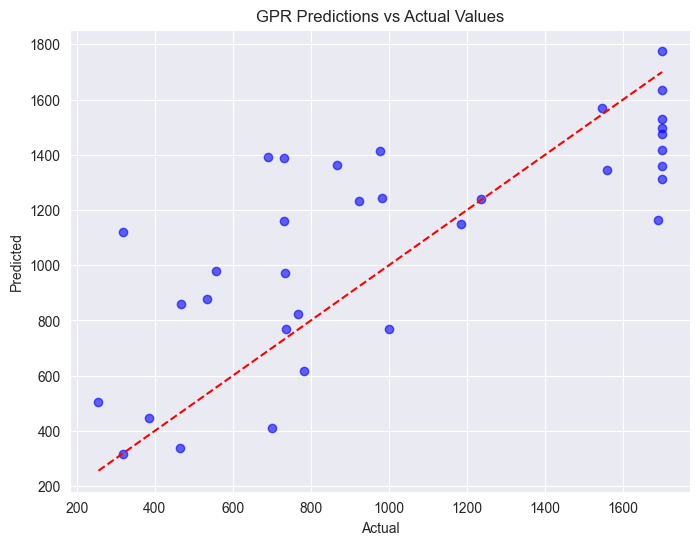

MSE: 115020.7414969058
Rsquared: 0.5410183310980823


In [40]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std=True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

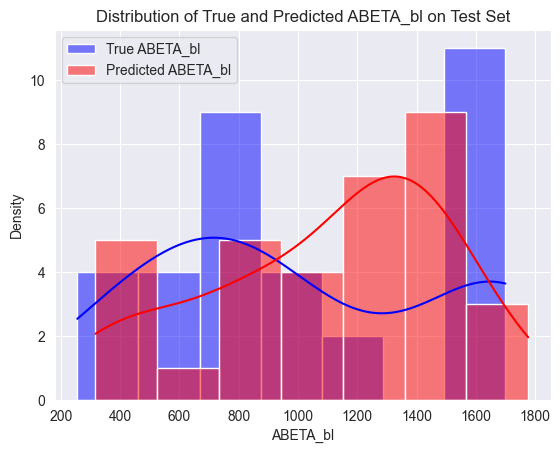

In [41]:
# Plot the distribution of test set predictions and the true values
sns.histplot(y_test, color='blue', label='True ABETA_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted ABETA_bl', kde=True)
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted ABETA_bl on Test Set')
plt.legend()
plt.show()

Predict PTAU_bl

In [205]:
X_train = whites_df.drop(columns=['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis=1)
y_train = whites_df['PTAU_bl']
X_test = non_whites_df.drop(columns=['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis=1)
y_test = non_whites_df['PTAU_bl']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(504, 177) (504,) (34, 177) (34,)


In [206]:
kernel = 1.00 * RationalQuadratic(length_scale=1e-3, alpha=0.01)

kmm = KMM(kernel=kernel, epsilon=0.1, bounding_weights=1000)

beta = kmm.fit(X_source=X_train, X_target=X_test)

print(f"Computed importance weights of shape: {beta.shape}")
X_train_weighted = X_train * beta
scaler = StandardScaler()
X_train_weighted = scaler.fit_transform(X_train_weighted)

print(f'Original X_train shape: {X_train.shape}')
print(f"Weighted X_train shape: {X_train_weighted.shape}")

print(f'is original X_train standardrized? {np.allclose(X_train.mean(axis=0), 0, atol=1e-7) and np.allclose(X_train.std(axis=0), 1, atol=1e-7)}')
print(f'is weighted X_train standardrized? {np.allclose(X_train_weighted.mean(axis=0), 0, atol=1e-7) and np.allclose(X_train_weighted.std(axis=0), 1, atol=1e-7)}')

Computed importance weights of shape: (504, 1)
Original X_train shape: (504, 177)
Weighted X_train shape: (504, 177)
is original X_train standardrized? True
is weighted X_train standardrized? True


In [ ]:
kernel = 1 * RBF(length_scale= 1e1,
                 length_scale_bounds = (1e1, 1e3))

gpr = GPRWrapper(
    kernel=kernel,
    alpha=5e-1,
    n_restarts_optimizer=10,
    random_state=42,
    normalize_y=True
)

search_params = {
    'kernel': Categorical([
        'RQ_1e-5', 'RQ_1e-4', 'RQ_1e-3', 'RQ_1e-2', 'RQ_1e-1', 'RQ_1e0', 'RQ_1e1', 'RQ_1e2',
        'RBF_1e-5', 'RBF_1e-4', 'RBF_1e-3', 'RBF_1e-2', 'RBF_1e-1', 'RBF_1e0', 'RBF_1e1', 'RBF_1e2',
        'Matern_1e-5', 'Matern_1e-4', 'Matern_1e-3', 'Matern_1e-2', 'Matern_1e-1', 'Matern_1e0', 'Matern_1e1', 'Matern_1e2'
    ]),
    'alpha': (1e-5, 1e2, 'log-uniform')
}

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_weighted, y_train)

print(f"Best parameters: {search.best_params_}, Best R2 score: {search.best_score_:.2f}")

In [207]:
gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=0.42,
                               n_restarts_optimizer=30,
                               random_state=42,
                               normalize_y=True)

gpr.fit(X_train_weighted, y_train)

,kernel,1**2 * Ration...h_scale=0.001)
,alpha,0.42
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr...h_scale=0.001)
,kernel__k1__constant_value,1.0


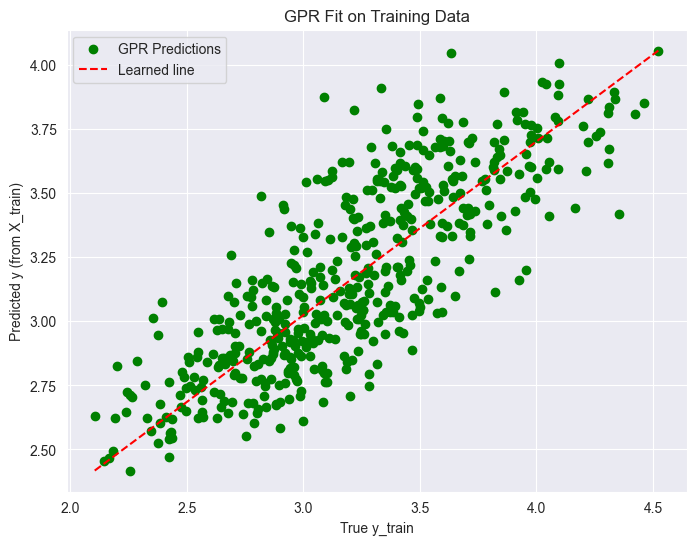

MSE: 0.08145176463140648
Rsquared: 0.6492261055627249


In [208]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label='Learned line')
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

In [ ]:
# Plot the distribution of training set predictions and the true values
sns.histplot(y_train, color='blue', label='True PTAU_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted PTAU_bl', kde=True)
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted PTAU_bl on Training Set')
plt.legend()
plt.show()

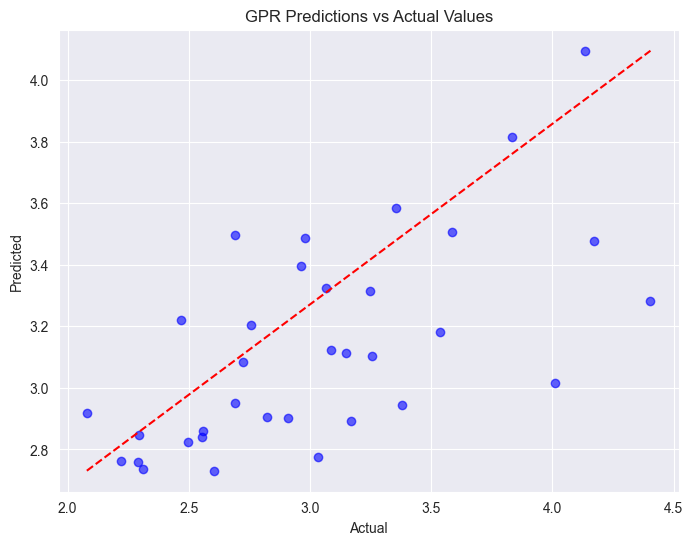

MSE: 0.21787568088074466
Rsquared: 0.3722588430541024


In [209]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std=True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()],
         'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

In [ ]:
# Plot the distribution of test set predictions and the true values
sns.histplot(y_test, color='blue', label='True PTAU_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted PTAU_bl', kde=True)
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted PTAU_bl on Test Set')
plt.legend()
plt.show()

Predict TAU_bl

In [210]:
X_train = whites_df.drop(columns=['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis=1)
y_train = whites_df['TAU_bl']
X_test = non_whites_df.drop(columns=['ABETA_bl', 'TAU_bl', 'PTAU_bl', 'PTRACCAT'], axis=1)
y_test = non_whites_df['TAU_bl']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(504, 177) (504,) (34, 177) (34,)


In [211]:
kernel = 1.00 * RationalQuadratic(length_scale=1e-4,
                                  alpha=0.01)

kmm = KMM(kernel=kernel, epsilon=0.1, bounding_weights=1000)

beta = kmm.fit(X_source=X_train, X_target=X_test)

print(f"Computed importance weights of shape: {beta.shape}")
X_train_weighted = X_train * beta
scaler = StandardScaler()
X_train_weighted = scaler.fit_transform(X_train_weighted)

print(f'Original X_train shape: {X_train.shape}')
print(f"Weighted X_train shape: {X_train_weighted.shape}")

print(f'is original X_train standardrized? {np.allclose(X_train.mean(axis=0), 0, atol=1e-7) and np.allclose(X_train.std(axis=0), 1, atol=1e-7)}')
print(f'is weighted X_train standardrized? {np.allclose(X_train_weighted.mean(axis=0), 0, atol=1e-7) and np.allclose(X_train_weighted.std(axis=0), 1, atol=1e-7)}')

Computed importance weights of shape: (504, 1)
Original X_train shape: (504, 177)
Weighted X_train shape: (504, 177)
is original X_train standardrized? True
is weighted X_train standardrized? True


In [ ]:
kernel = 1 * RBF(length_scale= 1e1,
                 length_scale_bounds = (1e1, 1e3))

gpr = GPRWrapper(
    kernel=kernel,
    alpha=5e-1,
    n_restarts_optimizer=10,
    random_state=42,
    normalize_y=True
)

search_params = {
    'kernel': Categorical([
        'RQ_1e-5', 'RQ_1e-4', 'RQ_1e-3', 'RQ_1e-2', 'RQ_1e-1', 'RQ_1e0', 'RQ_1e1', 'RQ_1e2',
        'RBF_1e-5', 'RBF_1e-4', 'RBF_1e-3', 'RBF_1e-2', 'RBF_1e-1', 'RBF_1e0', 'RBF_1e1', 'RBF_1e2',
        'Matern_1e-5', 'Matern_1e-4', 'Matern_1e-3', 'Matern_1e-2', 'Matern_1e-1', 'Matern_1e0', 'Matern_1e1', 'Matern_1e2'
    ]),
    'alpha': (1e-5, 1e2, 'log-uniform')
}

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_weighted, y_train)

print(f"Best parameters: {search.best_params_}, Best R2 score: {search.best_score_:.2f}")

In [212]:
gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=0.52,
                               n_restarts_optimizer=10,
                               random_state=42,
                               normalize_y=True)

gpr.fit(X_train_weighted, y_train)

,kernel,1**2 * Ration..._scale=0.0001)
,alpha,0.52
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr..._scale=0.0001)
,kernel__k1__constant_value,1.0


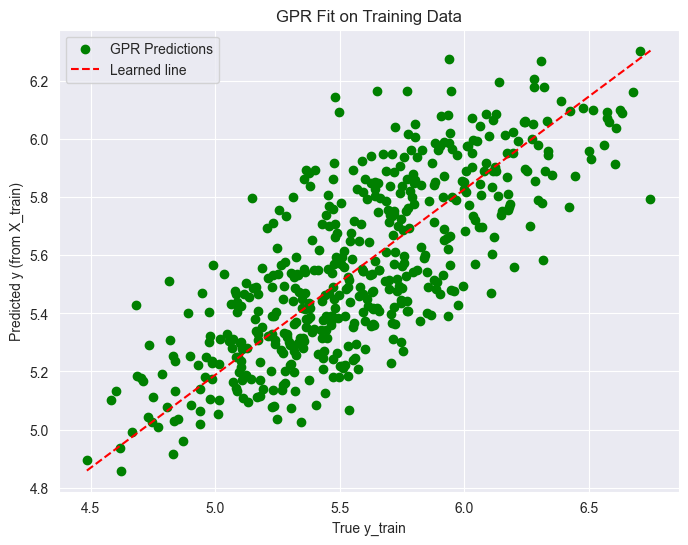

MSE: 0.07860517511546712
Rsquared: 0.5807903017382401


In [213]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label='Learned line')
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

In [ ]:
# Plot the distribution of training set predictions and the true values
sns.histplot(y_train, color='blue', label='True TAU_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted TAU_bl', kde=True)
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted TAU_bl on Training Set')
plt.legend()
plt.show()

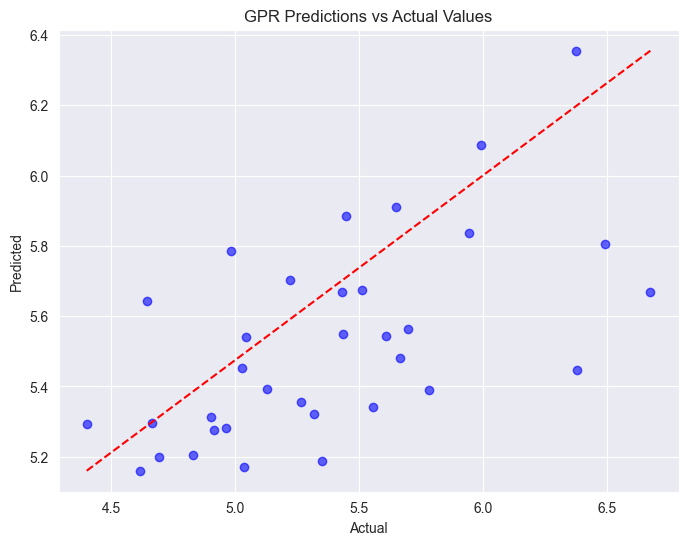

MSE: 0.2265189415120871
Rsquared: 0.28189977538205535


In [214]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std=True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()],
         'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

In [ ]:
# Plot the distribution of test set predictions and the true values
sns.histplot(y_test, color='blue', label='True TAU_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted TAU_bl', kde=True)
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted TAU_bl on Test Set')
plt.legend()
plt.show()